In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [116]:
def simulateDiversity(LL, SNRdB, decisionRule, VERBOSE=True):
    # simulateDiversity - script to simulate receiver diversity in Rayleigh fading channels
    #
    # For a given SNR and diversity order L, simulate the transmission of
    # random BPSK symbols with the objective to estimate the bit error
    # probability.
    #
    # There are L narrowband channels between the transmitter and the receiver.
    # These channels are modeled as having a Rayleigh distributed gain. The
    # channels also introduce white Gaussian noise.
    #
    # One symbol transmission is simulated at a time; each symbol is sent over
    # a new set of channels to guarantee that averaging over the channel
    # statistics occurs.
    #
    # Besides the bit error rate, the outage probability is estimated as well.

    # if SNR drops below this level, then an outage occurs
    OutageLeveldB = 0

    # stop criterion for simulation
    MAX_ERRORS = 400 # stop after this many errors
    MAX_SYMBOLS = 10000 # or this many symbols


    # derived parameters
    SNR = 10**(SNRdB/10)
    OutageLevel = 10**(OutageLeveldB/10)

    ## Simulation loop
    # initialization
    isDone = False
    numErrors = 0
    numSymbols = 0
    numOut = 0

    while not isDone:
        # transmitter
        symbol = 2*(np.random.uniform() > 0.5) - 1 # equally likely +/-1 symbols

        # channel
        # complex Gaussian channel gains - variance 1
        hh = 1/np.sqrt(2)*(np.random.normal(size=LL) + 1j*np.random.normal(size=LL))

        # complex Gaussian noise - variance 1/SNR since a^2=1
        ww = 1/np.sqrt(2*SNR)*(np.random.normal(size=LL) + 1j*np.random.normal(size=LL))

        # matched filter output
        rxSig = symbol*hh + ww

        instSNR, estSymbol = decisionRule(hh, rxSig)

        # update counts
        if estSymbol != symbol:
            numErrors = numErrors + 1

        if instSNR < OutageLevel:
            numOut = numOut + 1;

        numSymbols = numSymbols+1;

        # update termination criterion
        isDone = numErrors >= MAX_ERRORS or numSymbols >= MAX_SYMBOLS;

        if VERBOSE:
            if numSymbols % 10000 == 0:
                print('Transmitted {:d} symbols, found {:d} errors ({:6.3g} percent)'.
                      format(numSymbols, numErrors, 100*numErrors/numSymbols))

    ## Report results
    err_rate = numErrors/numSymbols
    err_conf_int = 1.96/numSymbols*np.sqrt(numErrors*(1-numErrors/numSymbols))
    if VERBOSE:
        print('\n\nTransmitted symbols: {:d}'.format(numSymbols))
        print('Number of symbol Errors: {:d}'.format(numErrors))
        print('Symbol Error Rate: {:6.3g}'.format(err_rate))
        print('95-percent confidence interval: {:6.3g}'.format(err_conf_int))
        print('\nNumber of Outages: {:d}'.format(numOut))
        print('Outage Rate: {:6.3g}'.format(numOut/numSymbols))
        print('95-percent confidence interval: {:6.3g}'.format(1.96/numSymbols*np.sqrt(numOut*(1-numOut/numSymbols))))
    return err_rate, err_conf_int

In [117]:
def no_diversity(channel, rxSig):
    # receiver - consists of combiner and decision
    # a really bad combiner, uses just one channel :-(
    rxCombined = rxSig[0]*np.conj(channel[0]) 
    # instantaneous SNR for this receiver
    instSNR = SNR*np.abs(channel[0])**2
    # decision
    estSymbol = np.sign(np.real(rxCombined));
    return instSNR, estSymbol

simulateDiversity(LL=4, SNRdB=10, decisionRule=no_diversity)

Transmitted 10000 symbols, found 195 errors (  1.95 percent)


Transmitted symbols: 10000
Number of symbol Errors: 195
Symbol Error Rate: 0.0195
95-percent confidence interval: 0.00271

Number of Outages: 97
Outage Rate: 0.0097
95-percent confidence interval: 0.00192


(0.0195, 0.0027101740091735808)

In [118]:
def selection_diversity(channel, rxSig):
    strongest_channel = np.argmax(np.abs(channel))
    rxCombined = rxSig[strongest_channel]*np.conj(channel[strongest_channel]) 
    # instantaneous SNR for this receiver
    instSNR = SNR*np.abs(channel[strongest_channel])**2
    # decision
    estSymbol = np.sign(np.real(rxCombined));
    return instSNR, estSymbol

simulateDiversity(LL=4, SNRdB=10, decisionRule=selection_diversity)

Transmitted 10000 symbols, found 3 errors (  0.03 percent)


Transmitted symbols: 10000
Number of symbol Errors: 3
Symbol Error Rate: 0.0003
95-percent confidence interval: 0.000339

Number of Outages: 0
Outage Rate:      0
95-percent confidence interval:      0


(0.0003, 0.00033943103217001243)

In [119]:
def maximum_ratio_combining_diversity(channel, rxSig):
    K = np.conj(channel) / np.linalg.norm(channel)
    rxCombined = K @ rxSig
    # instantaneous SNR for this receiver
    instSNR = 1 #SNR*np.abs(channel[strongest_channel])**2
    # decision
    estSymbol = np.sign(np.real(rxCombined));
    return instSNR, estSymbol

simulateDiversity(LL=4, SNRdB=10, decisionRule=maximum_ratio_combining_diversity)

Transmitted 10000 symbols, found 0 errors (     0 percent)


Transmitted symbols: 10000
Number of symbol Errors: 0
Symbol Error Rate:      0
95-percent confidence interval:      0

Number of Outages: 0
Outage Rate:      0
95-percent confidence interval:      0


(0.0, 0.0)

In [120]:
def strongest_signal_diversity(channel, rxSig):
    strongest_signal = np.argmax(np.abs(rxSig))
    rxCombined = rxSig[strongest_signal]*np.conj(channel[strongest_signal]) 
    # instantaneous SNR for this receiver
    instSNR = SNR*np.abs(channel[strongest_signal])**2
    # decision
    estSymbol = np.sign(np.real(rxCombined));
    return instSNR, estSymbol

simulateDiversity(LL=4, SNRdB=10, decisionRule=strongest_signal_diversity)

Transmitted 10000 symbols, found 3 errors (  0.03 percent)


Transmitted symbols: 10000
Number of symbol Errors: 3
Symbol Error Rate: 0.0003
95-percent confidence interval: 0.000339

Number of Outages: 1
Outage Rate: 0.0001
95-percent confidence interval: 0.000196


(0.0003, 0.00033943103217001243)

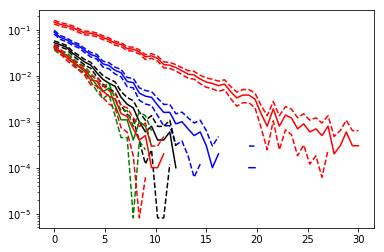

In [130]:
N_meas = 51
SNRdB = np.linspace(0,30, N_meas)
err_rate1 = np.empty(N_meas)
err_conf1 = np.empty(N_meas)
err_rate2 = np.empty(N_meas)
err_conf2 = np.empty(N_meas)
err_rate3 = np.empty(N_meas)
err_conf3 = np.empty(N_meas)
err_rate4 = np.empty(N_meas)
err_conf4 = np.empty(N_meas)
err_rate8 = np.empty(N_meas)
err_conf8 = np.empty(N_meas)
for i,SNR in enumerate(SNRdB):
    err_rate1[i], err_conf1[i] = simulateDiversity(LL=1, SNRdB=SNR, decisionRule=selection_diversity, VERBOSE=False)
    err_rate2[i], err_conf2[i] = simulateDiversity(LL=2, SNRdB=SNR, decisionRule=selection_diversity, VERBOSE=False)
    err_rate3[i], err_conf3[i] = simulateDiversity(LL=3, SNRdB=SNR, decisionRule=selection_diversity, VERBOSE=False)
    err_rate4[i], err_conf4[i] = simulateDiversity(LL=4, SNRdB=SNR, decisionRule=selection_diversity, VERBOSE=False)
    err_rate8[i], err_conf8[i] = simulateDiversity(LL=4, SNRdB=SNR, decisionRule=selection_diversity, VERBOSE=False)

plt.semilogy(SNRdB, err_rate1, 'r')
plt.semilogy(SNRdB, err_rate1+err_conf1, '--r')
plt.semilogy(SNRdB, err_rate1-err_conf1, '--r')

plt.semilogy(SNRdB, err_rate2, 'b')
plt.semilogy(SNRdB, err_rate2+err_conf2, '--b')
plt.semilogy(SNRdB, err_rate2-err_conf2, '--b')

plt.semilogy(SNRdB, err_rate3, 'k')
plt.semilogy(SNRdB, err_rate3+err_conf3, '--k')
plt.semilogy(SNRdB, err_rate3-err_conf3, '--k')

plt.semilogy(SNRdB, err_rate4, 'g')
plt.semilogy(SNRdB, err_rate4+err_conf4, '--g')
plt.semilogy(SNRdB, err_rate4-err_conf4, '--g')

plt.semilogy(SNRdB, err_rate8, 'r')
plt.semilogy(SNRdB, err_rate8+err_conf8, '--r')
plt.semilogy(SNRdB, err_rate8-err_conf8, '--r')

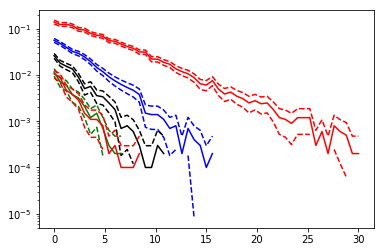

In [131]:
N_meas = 51
SNRdB = np.linspace(0,30, N_meas)
err_rate1 = np.empty(N_meas)
err_conf1 = np.empty(N_meas)
err_rate2 = np.empty(N_meas)
err_conf2 = np.empty(N_meas)
err_rate3 = np.empty(N_meas)
err_conf3 = np.empty(N_meas)
err_rate4 = np.empty(N_meas)
err_conf4 = np.empty(N_meas)
err_rate8 = np.empty(N_meas)
err_conf8 = np.empty(N_meas)
for i,SNR in enumerate(SNRdB):
    err_rate1[i], err_conf1[i] = simulateDiversity(LL=1, SNRdB=SNR, decisionRule=maximum_ratio_combining_diversity, VERBOSE=False)
    err_rate2[i], err_conf2[i] = simulateDiversity(LL=2, SNRdB=SNR, decisionRule=maximum_ratio_combining_diversity, VERBOSE=False)
    err_rate3[i], err_conf3[i] = simulateDiversity(LL=3, SNRdB=SNR, decisionRule=maximum_ratio_combining_diversity, VERBOSE=False)
    err_rate4[i], err_conf4[i] = simulateDiversity(LL=4, SNRdB=SNR, decisionRule=maximum_ratio_combining_diversity, VERBOSE=False)
    err_rate8[i], err_conf8[i] = simulateDiversity(LL=4, SNRdB=SNR, decisionRule=maximum_ratio_combining_diversity, VERBOSE=False)

plt.semilogy(SNRdB, err_rate1, 'r')
plt.semilogy(SNRdB, err_rate1+err_conf1, '--r')
plt.semilogy(SNRdB, err_rate1-err_conf1, '--r')

plt.semilogy(SNRdB, err_rate2, 'b')
plt.semilogy(SNRdB, err_rate2+err_conf2, '--b')
plt.semilogy(SNRdB, err_rate2-err_conf2, '--b')

plt.semilogy(SNRdB, err_rate3, 'k')
plt.semilogy(SNRdB, err_rate3+err_conf3, '--k')
plt.semilogy(SNRdB, err_rate3-err_conf3, '--k')

plt.semilogy(SNRdB, err_rate4, 'g')
plt.semilogy(SNRdB, err_rate4+err_conf4, '--g')
plt.semilogy(SNRdB, err_rate4-err_conf4, '--g')

plt.semilogy(SNRdB, err_rate8, 'r')
plt.semilogy(SNRdB, err_rate8+err_conf8, '--r')
plt.semilogy(SNRdB, err_rate8-err_conf8, '--r')

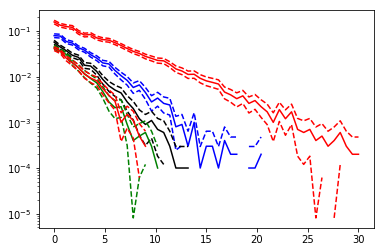

In [132]:
N_meas = 51
SNRdB = np.linspace(0,30, N_meas)
err_rate1 = np.empty(N_meas)
err_conf1 = np.empty(N_meas)
err_rate2 = np.empty(N_meas)
err_conf2 = np.empty(N_meas)
err_rate3 = np.empty(N_meas)
err_conf3 = np.empty(N_meas)
err_rate4 = np.empty(N_meas)
err_conf4 = np.empty(N_meas)
err_rate8 = np.empty(N_meas)
err_conf8 = np.empty(N_meas)
for i,SNR in enumerate(SNRdB):
    err_rate1[i], err_conf1[i] = simulateDiversity(LL=1, SNRdB=SNR, decisionRule=strongest_signal_diversity, VERBOSE=False)
    err_rate2[i], err_conf2[i] = simulateDiversity(LL=2, SNRdB=SNR, decisionRule=strongest_signal_diversity, VERBOSE=False)
    err_rate3[i], err_conf3[i] = simulateDiversity(LL=3, SNRdB=SNR, decisionRule=strongest_signal_diversity, VERBOSE=False)
    err_rate4[i], err_conf4[i] = simulateDiversity(LL=4, SNRdB=SNR, decisionRule=strongest_signal_diversity, VERBOSE=False)
    err_rate8[i], err_conf8[i] = simulateDiversity(LL=4, SNRdB=SNR, decisionRule=strongest_signal_diversity, VERBOSE=False)

plt.semilogy(SNRdB, err_rate1, 'r')
plt.semilogy(SNRdB, err_rate1+err_conf1, '--r')
plt.semilogy(SNRdB, err_rate1-err_conf1, '--r')

plt.semilogy(SNRdB, err_rate2, 'b')
plt.semilogy(SNRdB, err_rate2+err_conf2, '--b')
plt.semilogy(SNRdB, err_rate2-err_conf2, '--b')

plt.semilogy(SNRdB, err_rate3, 'k')
plt.semilogy(SNRdB, err_rate3+err_conf3, '--k')
plt.semilogy(SNRdB, err_rate3-err_conf3, '--k')

plt.semilogy(SNRdB, err_rate4, 'g')
plt.semilogy(SNRdB, err_rate4+err_conf4, '--g')
plt.semilogy(SNRdB, err_rate4-err_conf4, '--g')

plt.semilogy(SNRdB, err_rate8, 'r')
plt.semilogy(SNRdB, err_rate8+err_conf8, '--r')
plt.semilogy(SNRdB, err_rate8-err_conf8, '--r')